In [1]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import moscot.plotting as mpl
import mplscience
import numpy as np
import pandas as pd
from moscot.problems.time import TemporalProblem
import seaborn as sns
import os

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

['default', 'despine']


In [3]:
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/pancreas_2019/"

In [4]:
adata =sc.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/pancreas_2019/GSE132188_adata.h5ad.h5")

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [5]:
adata.obs["day"] = adata.obs["day"].astype(float).astype("category")

In [6]:
adata.obs["cell_type"] = adata.obs["clusters_fig6_fine_final"].copy()

In [7]:
endocrine_cells = ["Alpha", "Beta", "Epsilon", "Delta", "Fev+ Epsilon", "Fev+ Delta", "Fev+ Pyy", "Fev+ Alpha", "Fev+ Beta", "Ngn3 High early", "Ngn3 High late", "Ngn3 low EP"]

In [8]:
adata = adata[adata.obs["cell_type"].isin(endocrine_cells)]

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [9]:
order_celltypes = ["Ngn3 low EP", "Ngn3 High early", "Ngn3 High late",  "Fev+ Epsilon", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+ Pyy", "Alpha", "Beta", "Delta", "Epsilon"]


In [10]:
adata.obs["cell_type"] = adata.obs["cell_type"].cat.set_categories(order_celltypes)

/tmp/ipykernel_3075854/2607433252.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cell_type"] = adata.obs["cell_type"].cat.set_categories(order_celltypes)


In [11]:
color_dict = {'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Fev+ Epsilon': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#42f5ec', 'Fev+ Delta': '#aec7e8',
        'Ngn3 High early': '#ff9896', 'Ngn3 High late': '#ff9896', 'Ngn3 High early':'#f0b98d', 'Ngn3 low EP': '#c5b0d5', 'Fev+ Pyy': '#f5cb42',
}



In [12]:
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")
adata.uns["cell_type_colors"] = [color_dict[ct] for ct in adata.obs["cell_type"].cat.categories]

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)


In [14]:
sc.pp.neighbors(adata)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

In [15]:
tp = TemporalProblem(adata)

In [16]:
tp = tp.prepare("day", joint_attr="X_pca")

/home/icb/dominik.klein/git_repos/moscot/src/moscot/problems/time/_mixins.py:1036: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not (is_categorical_dtype(col) and is_numeric_dtype(col.cat.categories)):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [17]:


dfs = {}
batch_column = "day"
unique_batches = [12.5, 13.5, 14.5, 15.5]
for i in range(len(unique_batches) - 1):
    batch1 = unique_batches[i]
    batch2 = unique_batches[i + 1]

    indices = np.where((adata.obs[batch_column] == batch1) | (adata.obs[batch_column] == batch2))[0]
    adata_subset = adata[indices]
    sc.pp.neighbors(adata_subset, use_rep="X_pca")
    dfs[(batch1, batch2)] = (
        pd.DataFrame(
            index=adata_subset.obs_names,
            columns=adata_subset.obs_names,
            data=adata_subset.obsp["connectivities"].A.astype("float64")
        )
    )

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [18]:
tp[12.5, 13.5].set_graph_xy(dfs[12.5, 13.5], t=100)
tp[13.5, 14.5].set_graph_xy(dfs[13.5, 14.5], t=100)
tp[14.5, 15.5].set_graph_xy(dfs[14.5, 15.5], t=100)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [19]:
tp.solve(max_iterations=1e7)

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1745, 4417)].                                  


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1234, 1745)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(4417, 2780)].                                  


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


TemporalProblem[(13.5, 14.5), (12.5, 13.5), (14.5, 15.5)]

In [21]:
from cellrank.kernels import RealTimeKernel
tmk = RealTimeKernel.from_moscot(tp)

In [22]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.001, threshold="auto")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 856.56time pair/s]


RealTimeKernel[n=10176, threshold='auto', self_transitions='all']

In [23]:
import cellrank
g = cellrank.estimators.GPCCA(tmk)

In [24]:
g.fit(cluster_key="cell_type", n_states=25)

GPCCA[kernel=RealTimeKernel[n=10176], initial_states=None, terminal_states=None]

In [26]:
g.macrostates.cat.categories

Index(['Ngn3 low EP_1', 'Ngn3 low EP_2', 'Delta', 'Ngn3 low EP_3',
       'Fev+ Beta_1', 'Ngn3 low EP_4', 'Beta_1', 'Fev+ Epsilon',
       'Ngn3 High late_1', 'Fev+ Delta', 'Alpha_1', 'Beta_2', 'Fev+ Pyy',
       'Epsilon', 'Alpha_2', 'Beta_3', 'Ngn3 low EP_5', 'Ngn3 low EP_6',
       'Ngn3 low EP_7', 'Alpha_3', 'Fev+ Beta_2', 'Ngn3 High late_2',
       'Ngn3 High late_3', 'Fev+ Beta_3', 'Fev+ Beta_4'],
      dtype='object')

In [28]:
g.set_terminal_states(states=["Alpha_1", "Beta_1", "Epsilon", "Delta"])

GPCCA[kernel=RealTimeKernel[n=10176], initial_states=None, terminal_states=['Alpha_1', 'Beta_1', 'Delta', 'Epsilon']]

In [29]:
g.compute_fate_probabilities()

Defaulting to `'gmres'` solver.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.34s/]


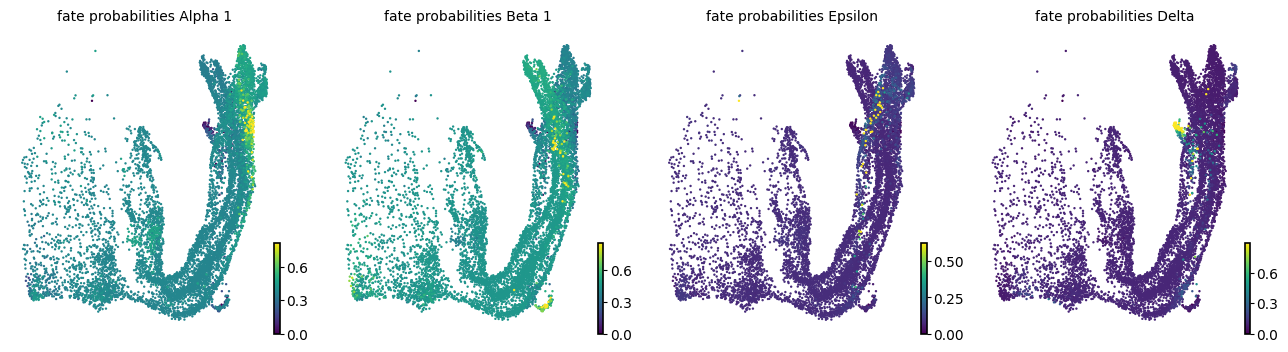

In [30]:
g.plot_fate_probabilities(same_plot=False)

In [ ]:
adata.obs[]

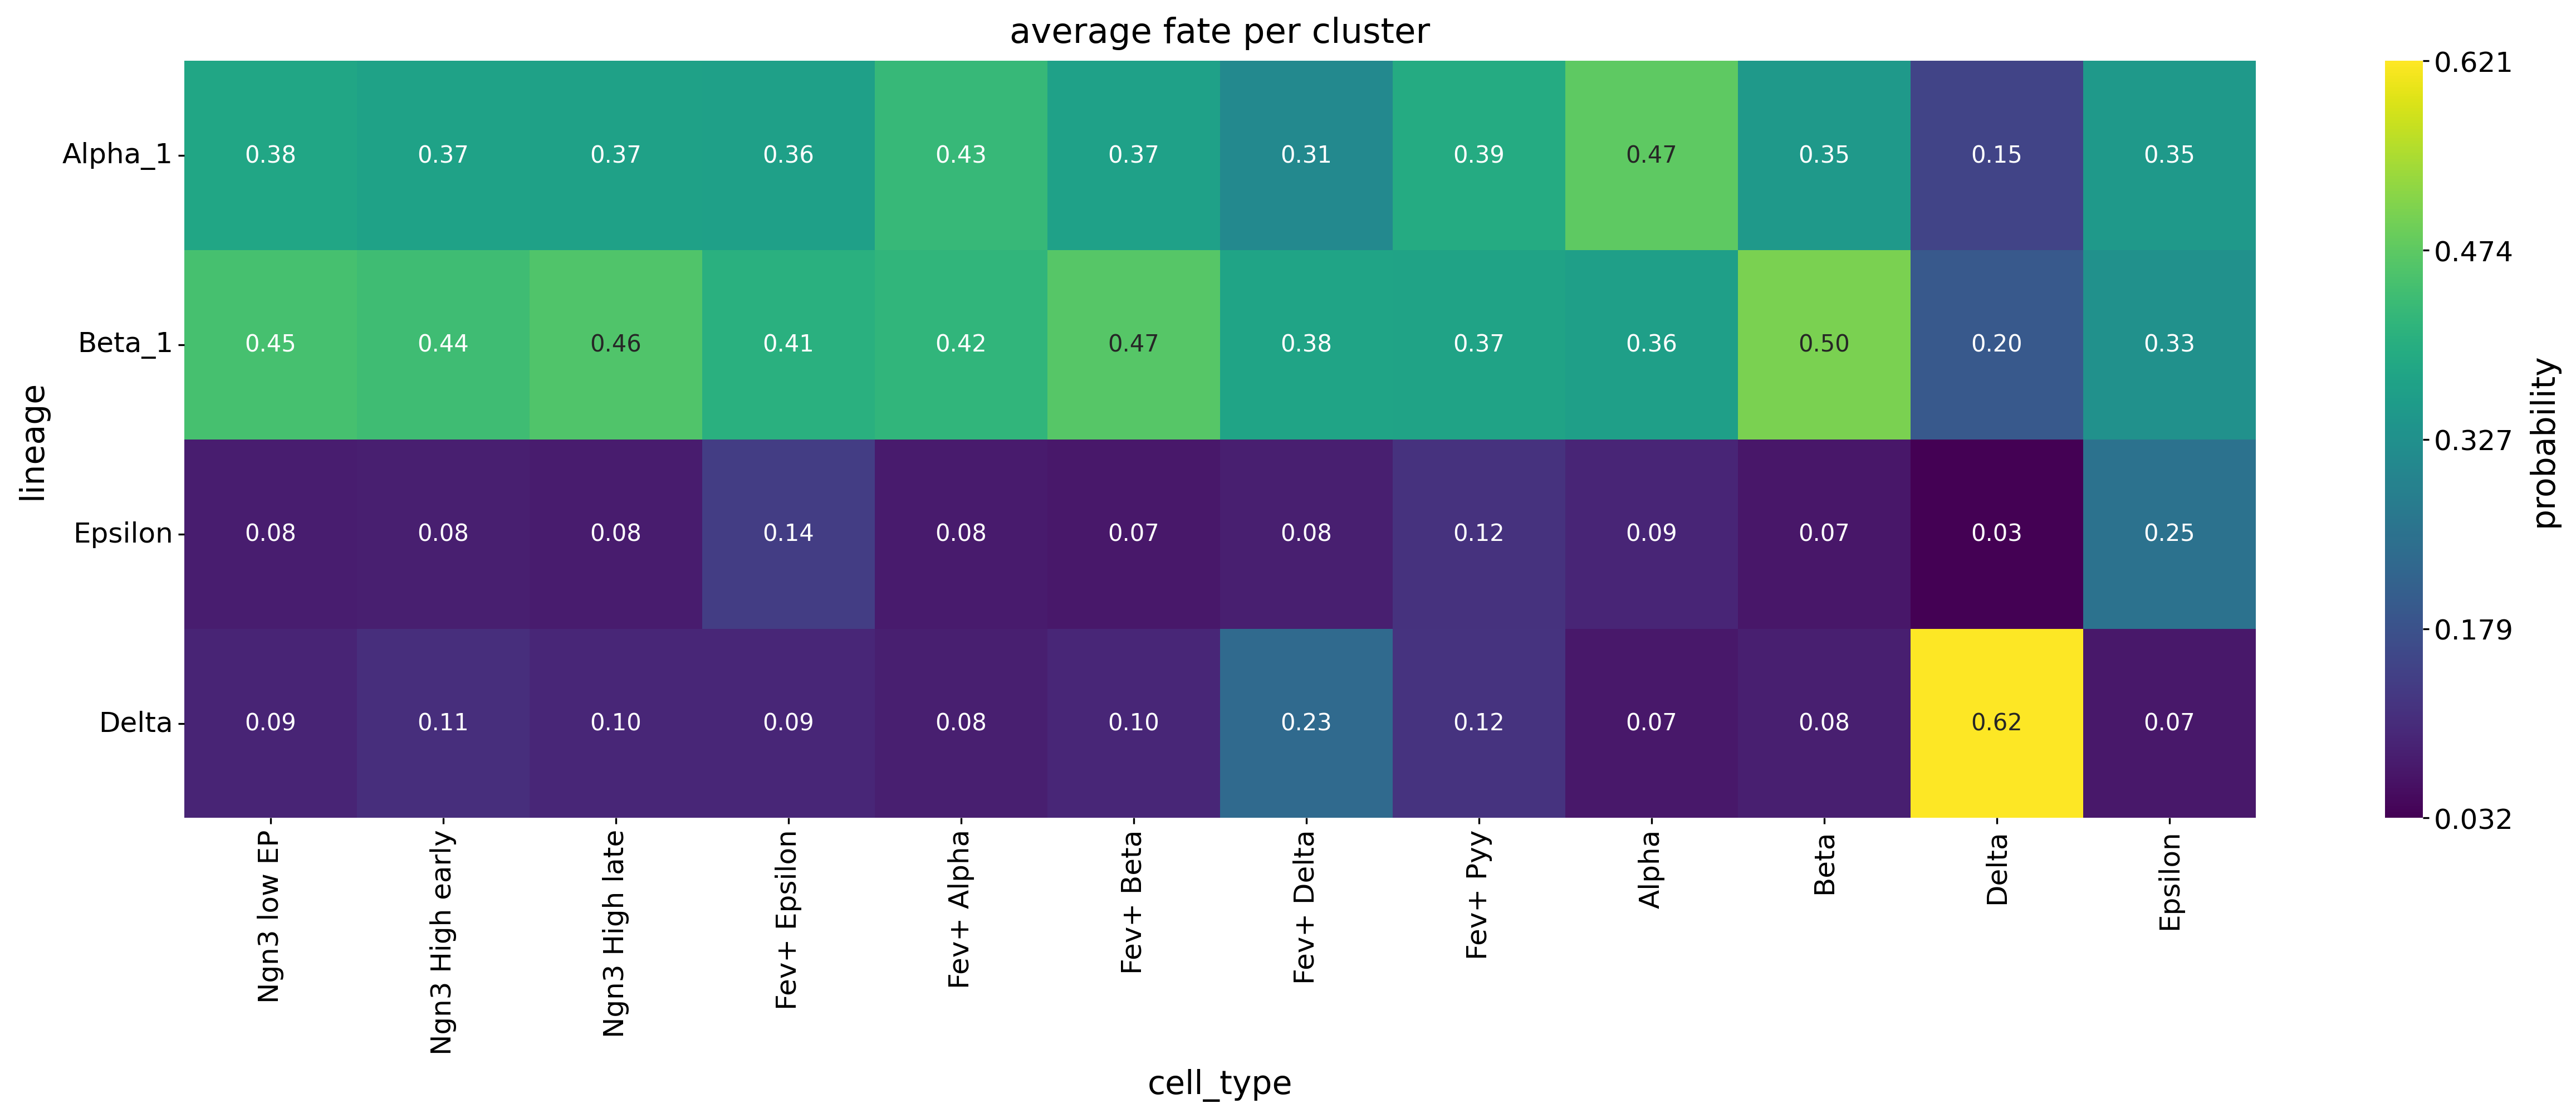

In [32]:
cellrank.pl.aggregate_fate_probabilities(
        adata=adata,
        mode='heatmap',
        lineages=["Alpha_1", "Beta_1", "Epsilon", "Delta"],
        cluster_key="cell_type",
        clusters=None,
        figsize=(20, 6),
        dpi=300,
    )

In [33]:
order_celltypes = ["Ngn3 low EP", "Ngn3 High early", "Ngn3 High late", "Fev+ Beta", "Beta", "Fev+ Alpha", "Alpha", "Fev+ Pyy", "Fev+ Delta", "Fev+ Epsilon", "Delta", "Epsilon"]


In [34]:
adata.obs["cell_type"] = adata.obs["cell_type"].cat.set_categories(order_celltypes)

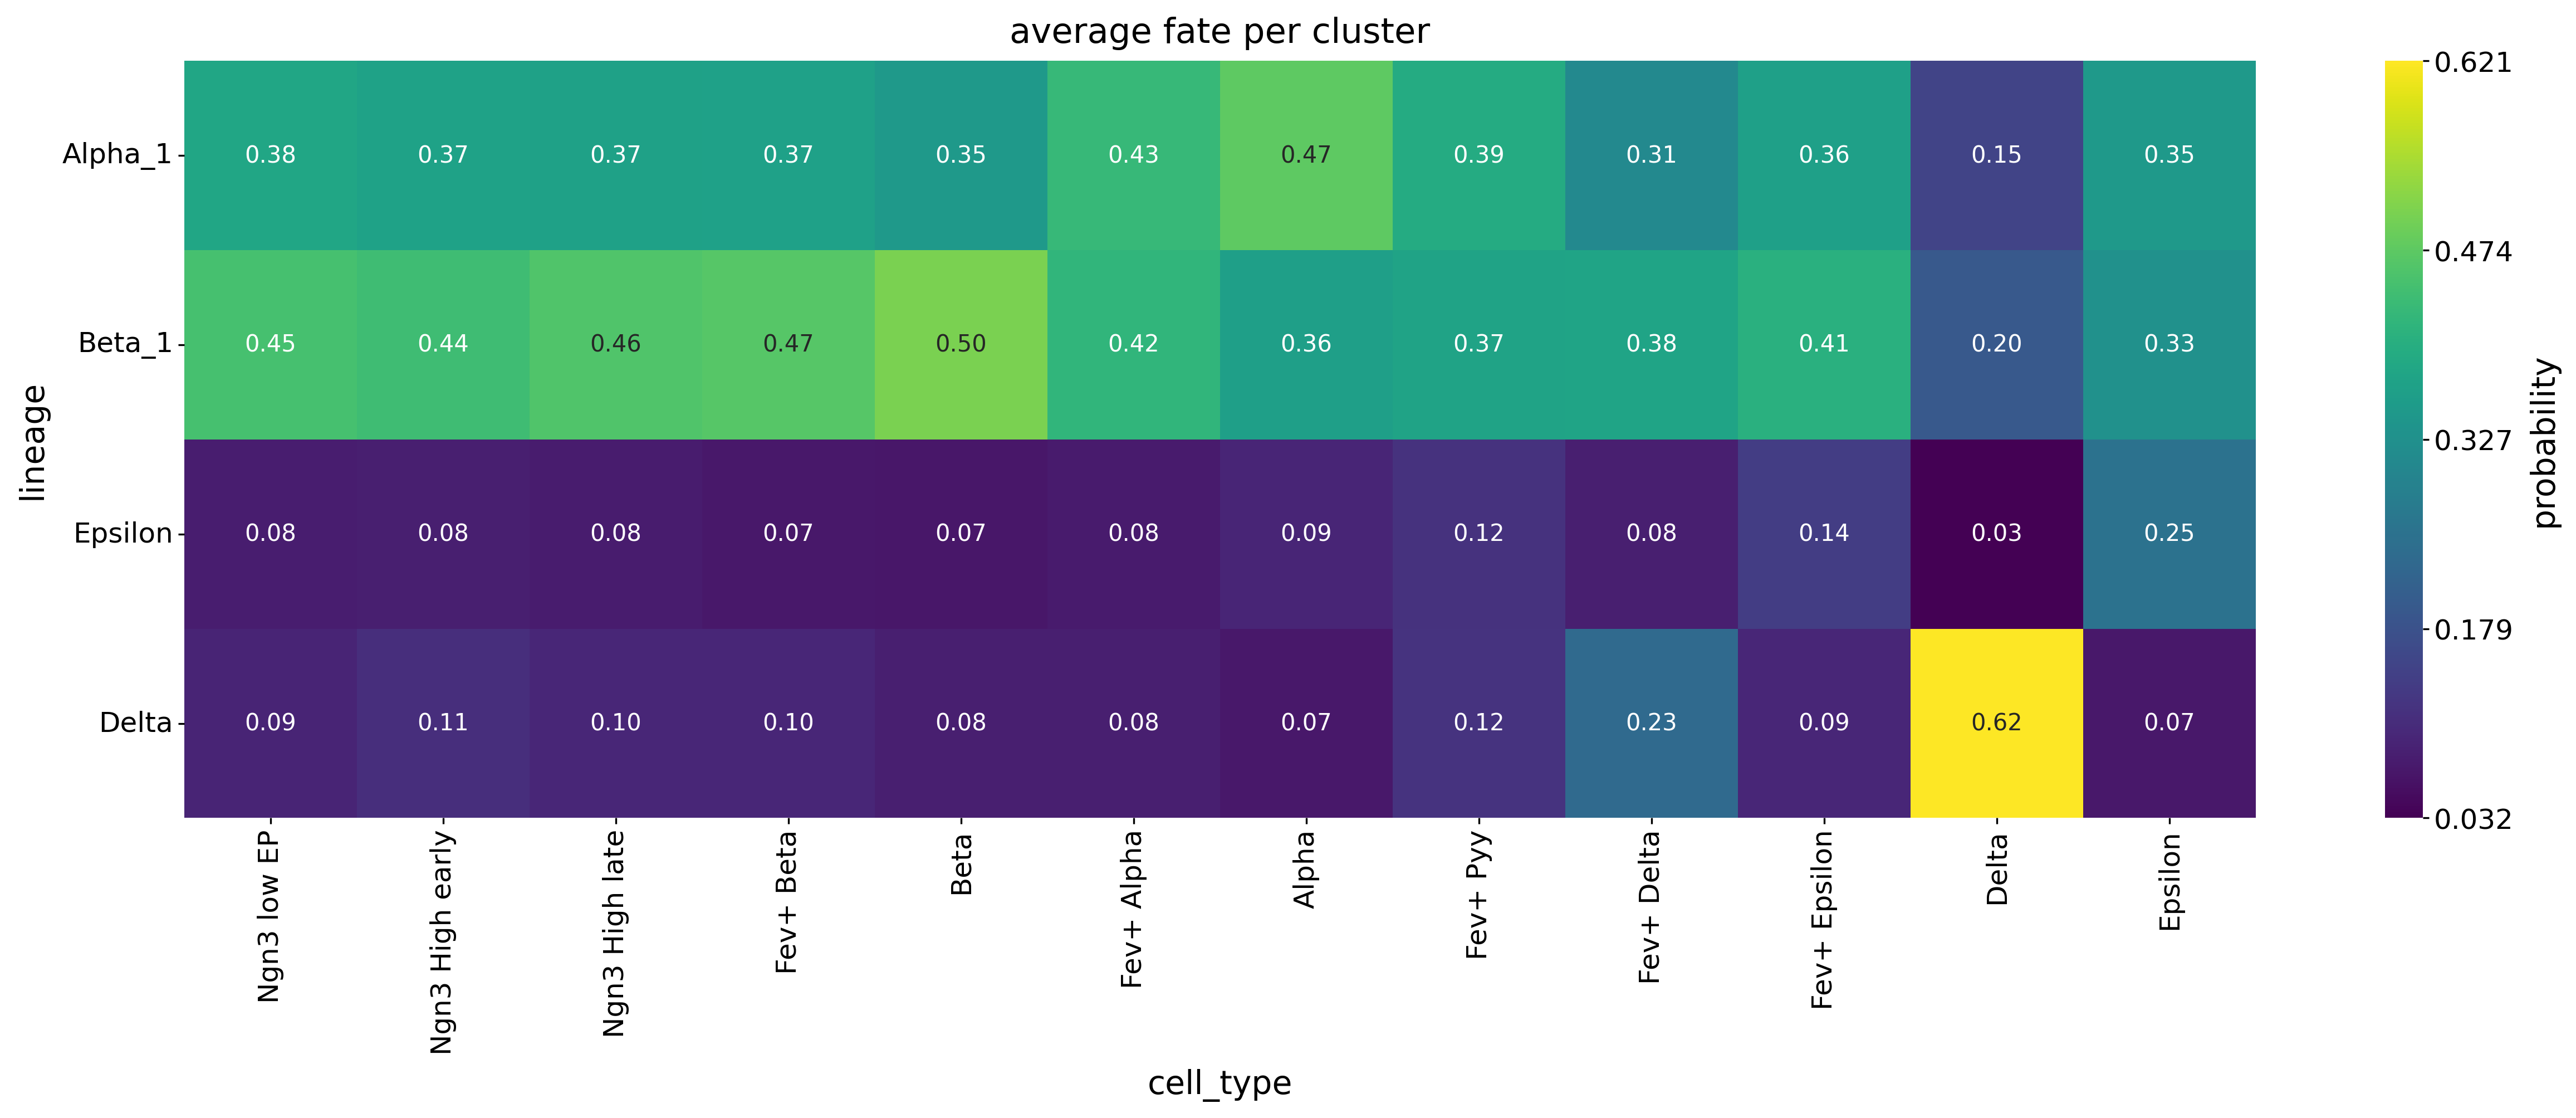

In [35]:
cellrank.pl.aggregate_fate_probabilities(
        adata=adata,
        mode='heatmap',
        lineages=["Alpha_1", "Beta_1", "Epsilon", "Delta"],
        cluster_key="cell_type",
        clusters=None,
        figsize=(20, 6),
        dpi=300,
    )